##### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, PReLU, Dense, LSTM, multiply, concatenate, Activation, Flatten
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Bidirectional
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

C:\Users\uzair\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


##### Label encoder (1/2 -> 0/1) and separate label from train and test

In [2]:
raw_data = np.loadtxt('exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt('exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

##### Scaling

In [3]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [4]:
y_uniques = np.unique(y_train)
n_classes = len(y_uniques)

##### Add validation set (split train set)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train,
                                                  test_size=0.3, random_state=123)

#### Shapes

In [6]:
np.set_printoptions(threshold=np.inf)

In [7]:
X_train_r = np.expand_dims(X_train, axis=2)
X_val_r = np.expand_dims(X_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

#### Create model

In [8]:
ip = Input(shape=(3197, 1))

##### LSTM

In [9]:
x = Permute((2, 1))(ip)

In [10]:
x = Bidirectional(LSTM(8))(x)

In [11]:
x = Dropout(0.8)(x)

#### Conv1D

In [12]:
y = Conv1D(8, 11, padding='same', kernel_initializer='he_uniform')(ip)
y = BatchNormalization()(y)
y = Activation('relu')(y)

In [13]:
y = Conv1D(16, 11, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

In [14]:
y = Conv1D(32, 11, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

In [15]:
y = Conv1D(64, 11, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

In [16]:
y = GlobalAveragePooling1D()(y)

#### Concat

In [17]:
x = concatenate([x, y])

In [18]:
out = Dense(1, activation='sigmoid')(x)

In [19]:
model = Model(ip, out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3197, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3197, 8)      96          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 3197, 8)      32          conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 3197, 8)      0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv1d_2 (

In [20]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [ ]:
model.compile(optimizer=SGD(lr=0.01, momentum=0.8), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.compile(optimizer=Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
hist = model.fit_generator(batch_generator(X_train_r, y_train, 32), 
                           validation_data=(X_val_r, y_val), 
                           epochs=40,
                           steps_per_epoch=X_train_r.shape[1]//32)

Epoch 1/40
99/99 [==============================] - 38s 388ms/step - loss: 0.4842 - acc: 0.7576 - val_loss: 0.1472 - val_acc: 0.9437
Epoch 2/40
99/99 [==============================] - 32s 324ms/step - loss: 0.3898 - acc: 0.8182 - val_loss: 0.0585 - val_acc: 0.9908
Epoch 3/40
99/99 [==============================] - 32s 323ms/step - loss: 0.3139 - acc: 0.8737 - val_loss: 0.0556 - val_acc: 0.9902
Epoch 4/40
99/99 [==============================] - 32s 324ms/step - loss: 0.2421 - acc: 0.9223 - val_loss: 0.0882 - val_acc: 0.9823
Epoch 5/40
99/99 [==============================] - 32s 324ms/step - loss: 0.1610 - acc: 0.9599 - val_loss: 0.0760 - val_acc: 0.9856
Epoch 6/40
99/99 [==============================] - 32s 324ms/step - loss: 0.1430 - acc: 0.9672 - val_loss: 0.1435 - val_acc: 0.9692
Epoch 7/40
99/99 [==============================] - 32s 323ms/step - loss: 0.1212 - acc: 0.9706 - val_loss: 0.1424 - val_acc: 0.9601
Epoch 8/40
99/99 [==============================] - 32s 324ms/step - 

In [23]:
y_pred = model.predict(x=x_test)

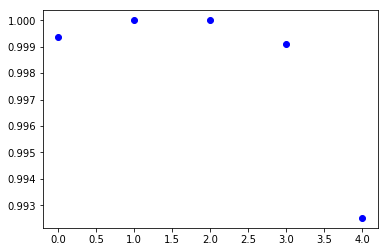

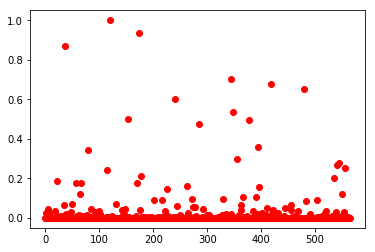

In [24]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
plt.plot([y_pred[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_pred[i] for i in non_idx], 'ro')
plt.show()

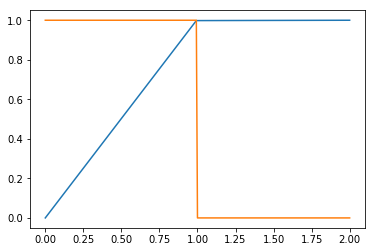

Crossover at 0.99 with specificity 1.00


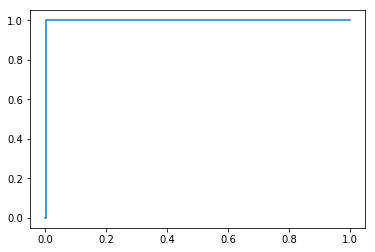

ROC area under curve is 1.00


In [25]:
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_pred)))

In [26]:
predy = np.where(y_pred > 0.99, 1, 0)

In [ ]:
predy

In [ ]:
print([y_pred[i] for i in yes_idx])

In [27]:
y_pred_bool = y_uniques[predy.argmax(1)]

In [ ]:
y_pred_bool

In [ ]:
sum(((y_pred_bool == y_test) & (y_test == 1)))

In [29]:
print(classification_report(y_test, predy))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       565
        1.0       0.83      1.00      0.91         5

avg / total       1.00      1.00      1.00       570



In [30]:
print(confusion_matrix(y_test, predy))

[[564   1]
 [  0   5]]


In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, predy).ravel()

In [32]:
tn

564

In [33]:
tp

5

In [34]:
fn

0

In [35]:
fp

1

In [ ]:
# model.save('models/my_model.h5')

# from keras.models import load_model

# model.save('my_model.h5') 